In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm import tqdm
import torch.cuda.amp as amp
import cv2
from torchvision.transforms import functional as F
from torch.utils.data import WeightedRandomSampler
from tqdm import tqdm
from torch.utils.data import random_split, WeightedRandomSampler


In [ ]:
# Creating a results folder
results_folder = '/content/drive/MyDrive/FoodSegmentation_Results_Final'
os.makedirs(results_folder, exist_ok=True)

In [ ]:
# Load category names

category_map = {}
category_file_path = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103/category_id.txt'

try:
    # manual parsing to support multi-word class names
    ids, names = [], []
    with open(category_file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) == 2:
                ids.append(int(parts[0]))
                names.append(parts[1])

    categories = pd.DataFrame({'id': ids, 'name': names})
    category_map = dict(zip(categories['id'], categories['name']))
    print(f"Successfully loaded {len(category_map)} categories.")

    if categories['id'].duplicated().any():
        print("Duplicate category ID's found")
    if not categories['id'].is_monotonic_increasing:
        print("Category IDs are not sorted; consider sorting for consistency.")

    # Save as CSV and Markdown
    categories.to_csv(f'{results_folder}/category_mapping.csv', index=False)
    with open(f'{results_folder}/category_table.md', 'w') as md_file:
        md_file.write('| Class ID | Category Name |\n')
        md_file.write('|----------|----------------|\n')
        for k, v in category_map.items():
            md_file.write(f'| {k} | {v} |\n')

    # Consistent color mapping
    cmap = cm.get_cmap('tab20', len(category_map))
    category_colors = {k: cmap(k) for k in category_map.keys()}

except Exception as e:
    print(f"Error loading category file: {e}")

Successfully loaded 104 categories.


<ipython-input-4-8e2fb5c9878e>:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(category_map))


In [ ]:
# Loading Paths
base_dir = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103/Images'
imageset_dir = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103/ImageSets'
train_list_file = os.path.join(imageset_dir, 'train.txt')
test_list_file = os.path.join(imageset_dir, 'test.txt')
train_img_path = os.path.join(base_dir, 'img_dir/train')
train_mask_path = os.path.join(base_dir, 'ann_dir/train')
test_img_path = os.path.join(base_dir, 'img_dir/test')
test_mask_path = os.path.join(base_dir, 'ann_dir/test')

In [ ]:
class FoodSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, list_file, transform_img=None, mask_size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        with open(list_file, 'r') as f:
            self.img_files = [line.strip() for line in f if line.strip().endswith('.jpg') or line.strip().endswith('.png')]
        self.transform_img = transform_img
        self.mask_size = mask_size

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        mask_path = os.path.join(self.mask_dir, img_file.replace('.jpg', '.png'))

        try:
            img = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path)
        except Exception as e:
            raise RuntimeError(f"Error reading file {img_file}: {e}")

        # Ensuring consistent size and robustness
        img = img.resize(self.mask_size, Image.BILINEAR)
        mask = mask.resize(self.mask_size, Image.NEAREST)

        if self.transform_img:
            img = self.transform_img(img)

        mask = np.array(mask, dtype=np.int64)

        # Checking for empty masks
        if np.all(mask == 0):
            print(f"Warning: Empty mask encountered for {img_file}")

        return img, torch.from_numpy(mask).long()


In [ ]:
# Transformers
transform_train = T.Compose([
    T.RandomResizedCrop((512, 512), scale=(0.85, 1.0)),  # dynamic cropping
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=15, scale=(0.95, 1.05), shear=5),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = T.Compose([
    T.Resize((512, 512)),
    T.CenterCrop((512, 512)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [ ]:
# Data Loaders with Optimized Weighted Sampling

# Calculating per image class based weights with downsampling
def compute_image_weights(dataset, downscale_size=(256, 256)):
    class_counts = np.zeros(104)
    image_weights = []

    for idx in tqdm(range(len(dataset)), desc="Computing class frequencies"):
        img_file = dataset.img_files[idx]
        mask_path = os.path.join(dataset.mask_dir, img_file.replace('.jpg', '.png'))
        mask = Image.open(mask_path).resize(downscale_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        unique_classes = np.unique(mask)
        for cls in unique_classes:
            class_counts[cls] += 1

    class_weights = 1.0 / (class_counts + 1e-6)

    for idx in tqdm(range(len(dataset)), desc="Assigning image weights"):
        img_file = dataset.img_files[idx]
        mask_path = os.path.join(dataset.mask_dir, img_file.replace('.jpg', '.png'))
        mask = Image.open(mask_path).resize(downscale_size, Image.NEAREST)
        mask = np.array(mask, dtype=np.int64)
        unique_classes = np.unique(mask)
        weight = np.sum(class_weights[unique_classes])
        image_weights.append(weight)

    return image_weights

# call full dataset and compute weights
full_train_dataset = FoodSegDataset(train_img_path, train_mask_path, list_file=train_list_file, transform_img=transform_train)
image_weights = compute_image_weights(full_train_dataset)
sampler = WeightedRandomSampler(image_weights, num_samples=len(image_weights), replacement=True)

val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
val_dataset.dataset.transform_img = transform_val

# Using weighted sampler for train
train_loader = DataLoader(train_dataset, batch_size=4, sampler=sampler, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=True, num_workers=4)

test_dataset = FoodSegDataset(test_img_path, test_mask_path, list_file=test_list_file, transform_img=transform_val)
test_loader = DataLoader(test_dataset, batch_size=4, pin_memory=True, num_workers=4)

Assigning image weights: 100%|██████████| 4983/4983 [00:30<00:00, 165.93it/s]


In [ ]:
# Model Setup
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 104, kernel_size=(1, 1))
model.cuda()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 223MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
scaler = amp.GradScaler()

<ipython-input-10-fbd6479b71a9>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None

    def check(self, current_score):
        if self.best_score is None or current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

best_model_path = os.path.join(results_folder, 'best_model.pth')
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [ ]:
# Split dataset first
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_dataset.dataset.transform_img = transform_val  # apply val transform

# Retrieve the subset indices from train_dataset
train_indices = train_dataset.indices  # crucial part

# Map image_weights to the correct subset
train_weights = [image_weights[i] for i in train_indices]

# Create the sampler using those weights
train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)

# Final loaders using sampler
train_loader = DataLoader(train_dataset, batch_size=4, sampler=train_sampler, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, pin_memory=True, num_workers=4)


In [ ]:
EPOCHS = 50
results = {'epoch': [], 'loss': [], 'val_mIoU': [], 'val_pixel_acc': [], 'val_dice': []}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        if imgs.ndim != 4 or imgs.shape[0] < 2 or imgs.shape[2] < 32 or imgs.shape[3] < 32:
            print(f'Skipping invalid train batch: {imgs.shape}')
            continue

        imgs, masks = imgs.cuda(), masks.cuda()
        optimizer.zero_grad()

        try:
            with torch.cuda.amp.autocast():
                outputs = model(imgs)['out']
                loss = loss_fn(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()

        except Exception as e:
            print(f"Train batch error: {e}")
            continue

    avg_loss = running_loss / len(train_loader)

    model.eval()
    val_miou, val_dice, val_pixel_acc = [], [], []

    with torch.no_grad():
        for imgs, masks in val_loader:
            if imgs.ndim != 4 or imgs.shape[0] < 2 or imgs.shape[2] < 32 or imgs.shape[3] < 32:
                print(f'Skipping invalid val batch: {imgs.shape}')
                continue

            imgs, masks = imgs.cuda(), masks.cuda()

            try:
                outputs = model(imgs)['out']
                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                gt_masks = masks.cpu().numpy()

                for pred_mask, gt_mask in zip(preds, gt_masks):
                    intersection = np.logical_and(pred_mask == gt_mask, gt_mask > 0).sum()
                    union = np.logical_or(pred_mask > 0, gt_mask > 0).sum()
                    iou = intersection / union if union > 0 else 0
                    val_miou.append(iou)

                    dice = (2. * intersection) / (pred_mask.size + gt_mask.size)
                    val_dice.append(dice)

                    pixel_acc = (pred_mask == gt_mask).mean()
                    val_pixel_acc.append(pixel_acc)

            except Exception as e:
                print(f"Validation batch error: {e}")
                continue

    # Results
    val_miou_mean = np.mean(val_miou)
    scheduler.step(val_miou_mean)

    results['epoch'].append(epoch + 1)
    results['loss'].append(avg_loss)
    results['val_mIoU'].append(val_miou_mean)
    results['val_pixel_acc'].append(np.mean(val_pixel_acc))
    results['val_dice'].append(np.mean(val_dice))

    # Saving best model
    if early_stopper.best_score is None or val_miou_mean > early_stopper.best_score:
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch {epoch+1}/{EPOCHS} — Loss: {avg_loss:.4f}, mIoU: {val_miou_mean:.4f}")

    if early_stopper.check(val_miou_mean):
        print("Early stopping triggered!")
        break


Epoch 1/50:   0%|          | 0/1122 [00:00<?, ?it/s]<ipython-input-13-0ce84153f73c>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 1122/1122 [09:15<00:00,  2.02it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 1/50 — Loss: 2.2337, mIoU: 0.2850


Epoch 2/50: 100%|██████████| 1122/1122 [05:04<00:00,  3.68it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 2/50 — Loss: 1.5876, mIoU: 0.3722


Epoch 3/50: 100%|██████████| 1122/1122 [04:08<00:00,  4.51it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 3/50 — Loss: 1.2730, mIoU: 0.4163


Epoch 4/50: 100%|██████████| 1122/1122 [04:07<00:00,  4.53it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 4/50 — Loss: 1.0631, mIoU: 0.4184


Epoch 5/50: 100%|██████████| 1122/1122 [03:57<00:00,  4.72it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 5/50 — Loss: 0.8847, mIoU: 0.4584


Epoch 6/50: 100%|██████████| 1122/1122 [03:59<00:00,  4.68it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 6/50 — Loss: 0.7709, mIoU: 0.4604


Epoch 7/50: 100%|██████████| 1122/1122 [03:57<00:00,  4.73it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 7/50 — Loss: 0.6513, mIoU: 0.4672


Epoch 8/50: 100%|██████████| 1122/1122 [03:58<00:00,  4.70it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 8/50 — Loss: 0.5748, mIoU: 0.4765


Epoch 9/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 9/50 — Loss: 0.5046, mIoU: 0.4807


Epoch 10/50: 100%|██████████| 1122/1122 [03:57<00:00,  4.73it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 10/50 — Loss: 0.4645, mIoU: 0.4698


Epoch 11/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 11/50 — Loss: 0.4069, mIoU: 0.4840


Epoch 12/50: 100%|██████████| 1122/1122 [03:57<00:00,  4.73it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 12/50 — Loss: 0.3770, mIoU: 0.4843


Epoch 13/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.73it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 13/50 — Loss: 0.3423, mIoU: 0.4856


Epoch 14/50: 100%|██████████| 1122/1122 [03:57<00:00,  4.73it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 14/50 — Loss: 0.3043, mIoU: 0.4797


Epoch 15/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 15/50 — Loss: 0.2985, mIoU: 0.4931


Epoch 16/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 16/50 — Loss: 0.2747, mIoU: 0.4980


Epoch 17/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 17/50 — Loss: 0.2483, mIoU: 0.5066


Epoch 18/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 18/50 — Loss: 0.2409, mIoU: 0.4977


Epoch 19/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 19/50 — Loss: 0.2239, mIoU: 0.5096


Epoch 20/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 20/50 — Loss: 0.2039, mIoU: 0.5124


Epoch 21/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.74it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 21/50 — Loss: 0.1926, mIoU: 0.5230


Epoch 22/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 22/50 — Loss: 0.1992, mIoU: 0.5022


Epoch 23/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 23/50 — Loss: 0.1712, mIoU: 0.5028


Epoch 24/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 24/50 — Loss: 0.1703, mIoU: 0.4853


Epoch 25/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 25/50 — Loss: 0.1300, mIoU: 0.5272


Epoch 26/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 26/50 — Loss: 0.1073, mIoU: 0.5150


Epoch 27/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 27/50 — Loss: 0.1000, mIoU: 0.5350


Epoch 28/50: 100%|██████████| 1122/1122 [03:56<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 28/50 — Loss: 0.0970, mIoU: 0.5340


Epoch 29/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 29/50 — Loss: 0.0965, mIoU: 0.5286


Epoch 30/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 30/50 — Loss: 0.0911, mIoU: 0.5288


Epoch 31/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 31/50 — Loss: 0.0761, mIoU: 0.5514


Epoch 32/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 32/50 — Loss: 0.0719, mIoU: 0.5360


Epoch 33/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 33/50 — Loss: 0.0665, mIoU: 0.5428


Epoch 34/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 34/50 — Loss: 0.0686, mIoU: 0.5471


Epoch 35/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.75it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 35/50 — Loss: 0.0616, mIoU: 0.5483


Epoch 36/50: 100%|██████████| 1122/1122 [03:55<00:00,  4.76it/s]

Skipping invalid train batch: torch.Size([1, 3, 512, 512])


Epoch 36/50 — Loss: 0.0580, mIoU: 0.5487
Early stopping triggered!


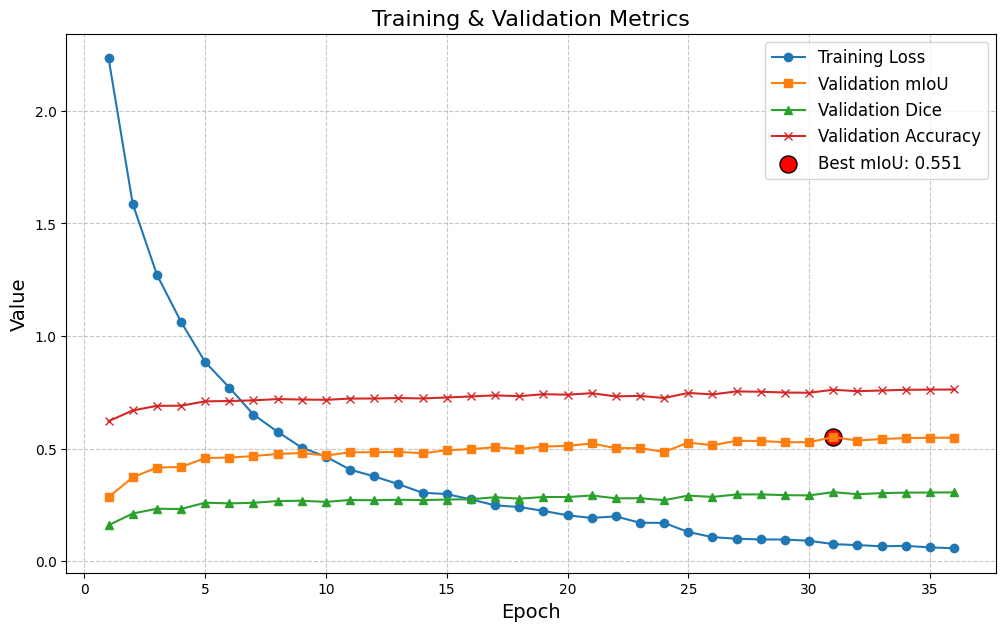

In [ ]:
# Save metrics & plotting
results_file = os.path.join(results_folder, 'training_results.csv')
pd.DataFrame(results).to_csv(results_file, index=False)

plt.figure(figsize=(12, 7))
plt.plot(results['epoch'], results['loss'], label='Training Loss', marker='o')
plt.plot(results['epoch'], results['val_mIoU'], label='Validation mIoU', marker='s')
plt.plot(results['epoch'], results['val_dice'], label='Validation Dice', marker='^')
plt.plot(results['epoch'], results['val_pixel_acc'], label='Validation Accuracy', marker='x')

# Highlighting the best val_mIoU epoch
best_epoch = results['val_mIoU'].index(max(results['val_mIoU']))
best_mIoU = max(results['val_mIoU'])
plt.scatter(results['epoch'][best_epoch], best_mIoU, color='red', s=150, label=f'Best mIoU: {best_mIoU:.3f}', edgecolors='black')

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Training & Validation Metrics', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(os.path.join(results_folder, 'training_metrics_plot.png'))
plt.show()


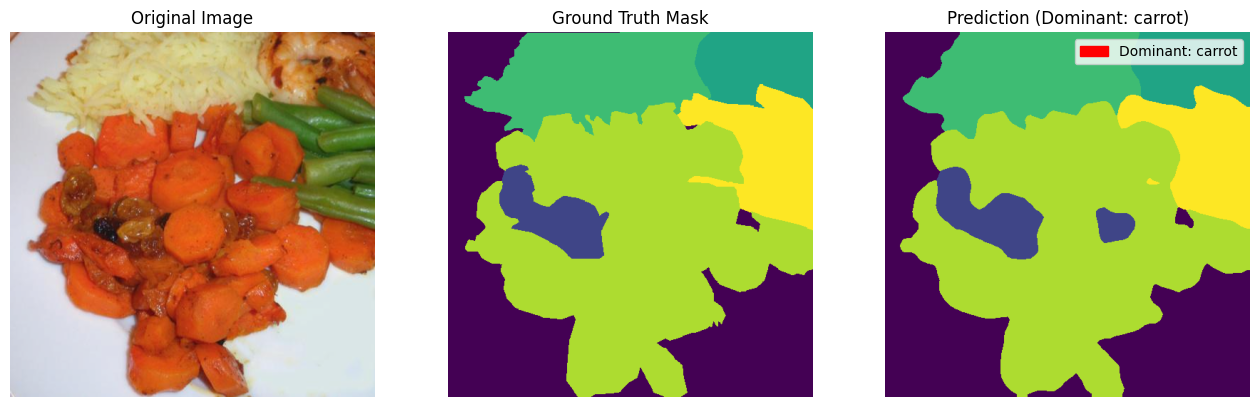

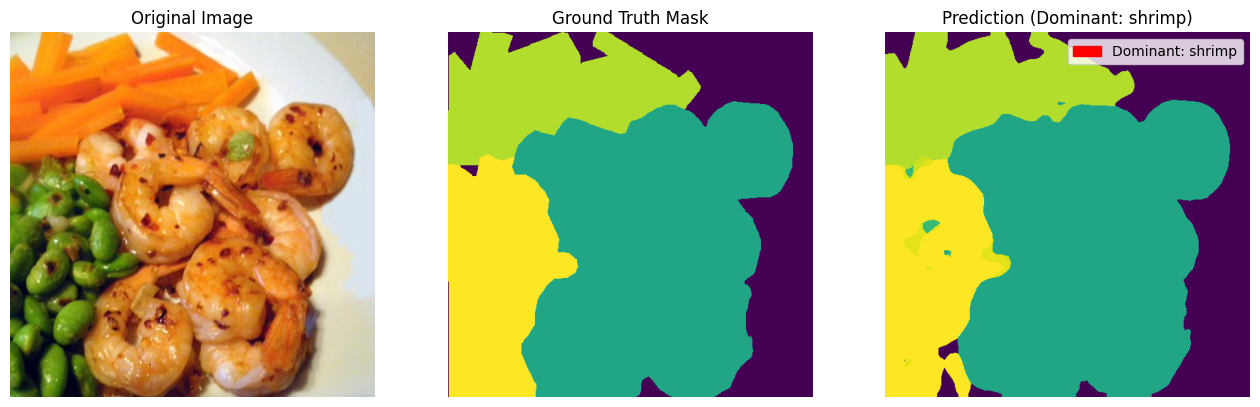

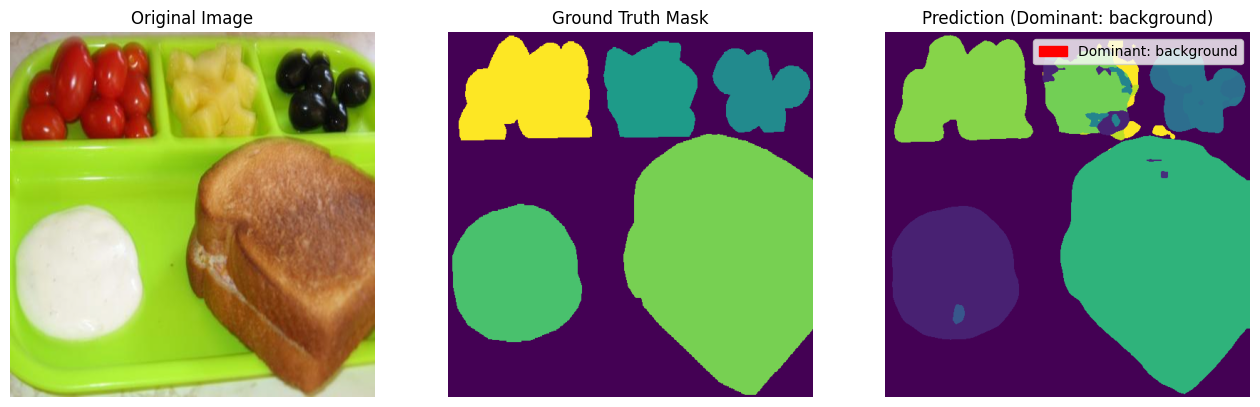

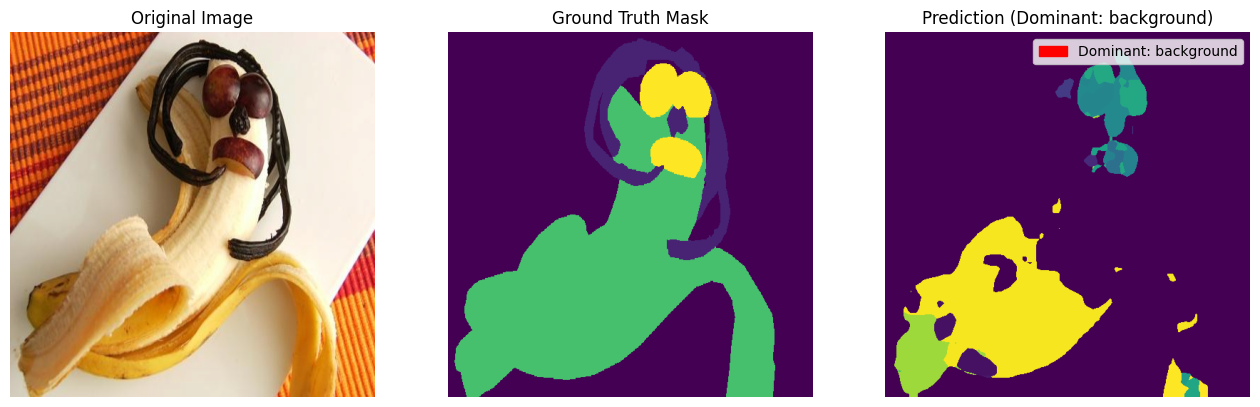

In [ ]:
# Visualize predictions and save results
model.load_state_dict(torch.load(best_model_path))
model.eval()

import matplotlib.patches as mpatches

with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.cuda(), masks.cuda()
        preds = torch.argmax(model(imgs)['out'], dim=1).cpu()

        for i in range(min(5, len(imgs))):  # show up to 5 samples
            plt.figure(figsize=(16, 5))

            # Original Image
            plt.subplot(1, 3, 1)
            img_np = imgs[i].permute(1, 2, 0).cpu().numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img_np = np.clip(img_np, 0, 1)
            plt.imshow(img_np)
            plt.title('Original Image')
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].cpu())
            plt.title('Ground Truth Mask')
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            pred_mask = preds[i]
            dominant_class = torch.mode(pred_mask.flatten())[0].item()
            plt.imshow(pred_mask)
            plt.title(f'Prediction (Dominant: {category_map.get(dominant_class, "Unknown")})')
            plt.axis('off')

            # Adding legend patch for dominant class
            legend_patch = mpatches.Patch(color='red', label=f'Dominant: {category_map.get(dominant_class, "Unknown")}')
            plt.legend(handles=[legend_patch], loc='upper right')

            # Save each visualization
            plt.savefig(os.path.join(results_folder, f'prediction_visualization_sample_{i}.png'))
            plt.show()

        break

## **Demo Function**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 179MB/s]


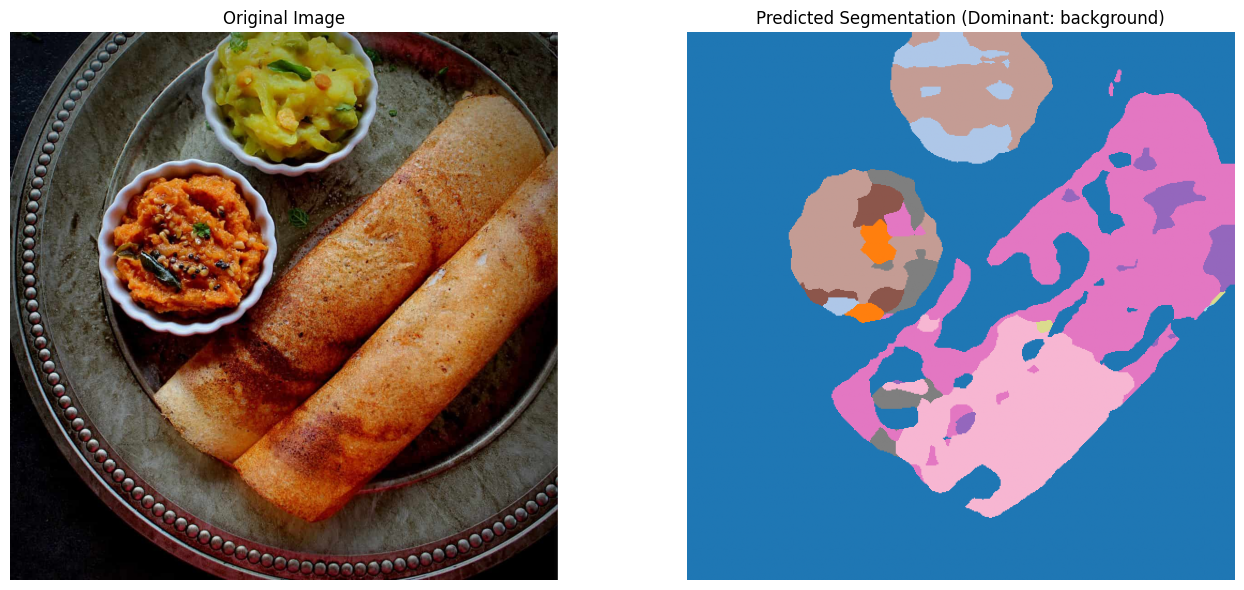

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T, models
import os

# Give Paths
image_path = '/content/drive/MyDrive/dosa.jpg'  # Any custom food image path
model_path = '/content/drive/MyDrive/FoodSegmentation_Results_Final/best_model.pth'
category_file_path = '/content/drive/MyDrive/Task 1 Food Segmentation Dataset/FoodSeg103/category_id.txt'

# Loading Category Map
category_map = {}
with open(category_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split(maxsplit=1)
        if len(parts) == 2:
            idx, name = parts
            category_map[int(idx)] = name
        else:
            print(f"Skipping malformed line: {line.strip()}")

# Image Transform according to Validation
transform_val = T.Compose([
    T.Resize((512, 512)),
    T.CenterCrop((512, 512)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Loading Trained Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 104, kernel_size=1)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Inference and Visualization Function
def predict_and_show_segmentation(image_path, model, transform, category_map):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    # Finding dominant class
    dominant_class = int(torch.mode(torch.tensor(pred_mask.flatten()))[0])
    class_name = category_map.get(dominant_class, "Unknown")

    # Visualization
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='tab20')  # Better color mapping
    plt.title(f"Predicted Segmentation (Dominant: {class_name})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

#  Function Call
predict_and_show_segmentation(image_path, model, transform_val, category_map)
